# Coffee Bean Classification

### Imports

In [103]:
import numpy as np
import pandas as pd
import tensorflow as tf
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Dense, Flatten, Activation
from keras.optimizers import Adam
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import random
import os
from glob import glob 
import warnings
import sys
if not sys.warnoptions:
    warnings.simplefilter("ignore")


## Data

### Loading dataset and checking classes

In [104]:
data = pd.read_csv('data\Coffee Bean.csv')
data.head()

,class index,filepaths,labels,data set
0,0,train/Dark/dark (1).png,Dark,train
1,0,train/Dark/dark (10).png,Dark,train
2,0,train/Dark/dark (100).png,Dark,train
3,0,train/Dark/dark (101).png,Dark,train
4,0,train/Dark/dark (102).png,Dark,train


In [105]:
classes = sorted(os.listdir('data/train/'))
print(classes)

photos_per_class = [len(glob('data/train/' + name + '/*.png')) for name in classes]
photos_per_class

['Dark', 'Green', 'Light', 'Medium']


[300, 300, 300, 300]

### Loading images

In [106]:
train_data_generator = ImageDataGenerator(
        rescale=1./255,
        horizontal_flip=True, 
        width_shift_range = 0.2, 
        height_shift_range = 0.2,
        shear_range = 0.2, 
        zoom_range = 0.2, 
        validation_split=0.3)

test_data_generator = ImageDataGenerator(rescale=1./255)

train_data = train_data_generator.flow_from_directory('data/train/', target_size=(224, 224), shuffle=True, 
                                                       subset='training', class_mode='categorical')
validation_data = train_data_generator.flow_from_directory('data/train/', target_size=(224, 224), shuffle=True, 
                                                       subset='validation', class_mode='categorical')
test_data = train_data_generator.flow_from_directory('data/test/', target_size=(224, 224), shuffle=True, 
                                                       class_mode='categorical')

Found 840 images belonging to 4 classes.
Found 360 images belonging to 4 classes.
Found 400 images belonging to 4 classes.


### Images from each class in train and test set

In [107]:
def show_image(target, bean_class):
    path = target + bean_class
    image = random.sample(os.listdir(path), 1)
    img = mpimg.imread(path + '/' + image[0])
    plt.imshow(img)
    plt.title(bean_class)
    plt.axis('off')

    return img

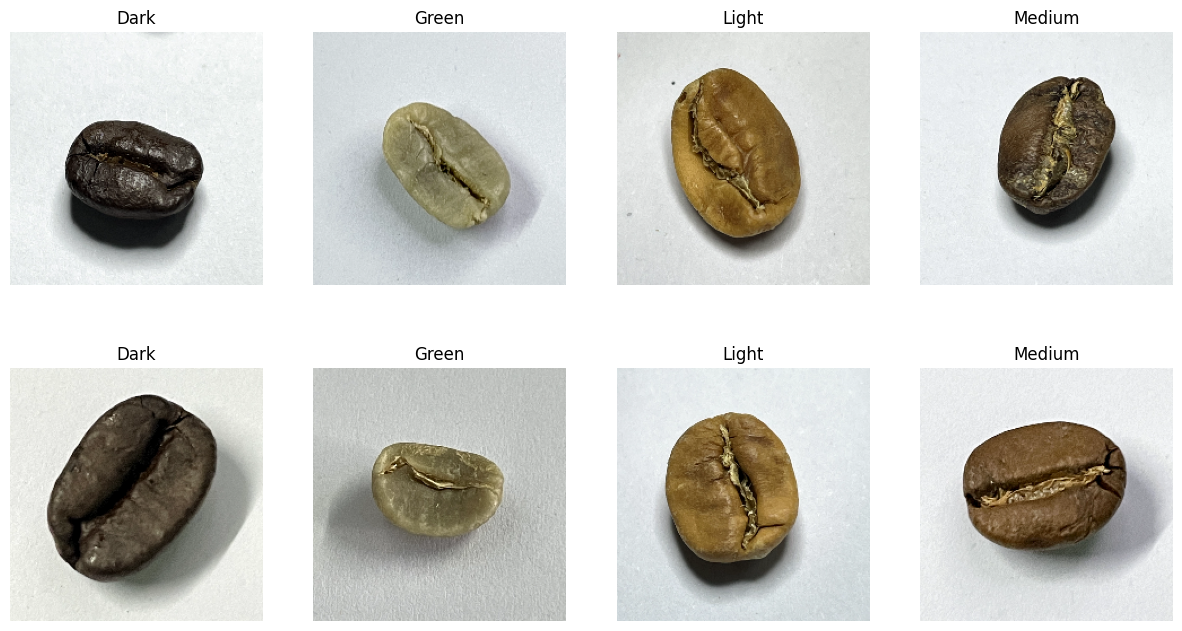

In [108]:
plt.figure(figsize = (15,8))
plt.subplot(2,4,1)
dark_bean_train = show_image('data/train/', 'Dark')
plt.subplot(2,4,2)
green_bean_train = show_image('data/train/', 'Green')
plt.subplot(2,4,3)
light_bean_train = show_image('data/train/', 'Light')
plt.subplot(2,4,4)
medium_bean_train = show_image('data/train/', 'Medium')
plt.subplot(2,4,5)
dark_bean_test = show_image('data/test/', 'Dark')
plt.subplot(2,4,6)
green_bean_test = show_image('data/test/', 'Green')
plt.subplot(2,4,7)
light_bean_test = show_image('data/test/', 'Light')
plt.subplot(2,4,8)
medium_bean_test = show_image('data/test/', 'Medium')

## Models

In [109]:
def plot_loss_curves(history):

  loss = history.history["loss"]
  val_loss = history.history["val_loss"]

  accuracy = history.history["accuracy"]
  val_accuracy = history.history["val_accuracy"]

  epochs = range(len(history.history["loss"]))

  #plot loss
  plt.plot(epochs, loss, label = "training_loss")
  plt.plot(epochs, val_loss, label = "val_loss")
  plt.title("loss")
  plt.xlabel("epochs")
  plt.legend()

  #plot accuracy
  plt.figure() 
  plt.plot(epochs, accuracy, label = "training_accuracy")
  plt.plot(epochs, val_accuracy, label = "val_accuracy")
  plt.title("accuracy")
  plt.xlabel("epochs")
  plt.legend()

In [110]:
def show_results(accuracy_list: list, labels: list):
    accuracy_score = pd.DataFrame(data = accuracy_list, columns = ['Scores'])
    accuracy_score.index = labels
    accuracy_score = (accuracy_score * 100).round(4)
    plt.xticks(rotation=90)
    plt.grid(visible=None)
    plt.scatter(x=accuracy_score.index, y=accuracy_score['Scores'], c=accuracy_score['Scores'], cmap='Dark2_r')
    for i in range(len(accuracy_score['Scores'])):
        plt.annotate(str(accuracy_score['Scores'][i]), (i, accuracy_score['Scores'][i]), textcoords="offset points", xytext=(0,10))
        
accuracy_list = []
labels = []

In [111]:
model_1 = Sequential()
model_1.add(Conv2D(32, (3,3), input_shape = (224,224,3), activation="relu"))
model_1.add(MaxPooling2D(2,2))
model_1.add(Conv2D(32, (3,3), activation="relu"))
model_1.add(MaxPooling2D(2,2))
model_1.add(Conv2D(32, (3,3), activation="relu"))
model_1.add(MaxPooling2D(2,2))
model_1.add(Flatten())
model_1.add(Dense(512, activation="relu"))
model_1.add(Dropout(0.2))
model_1.add(Dense(4, activation='softmax'))

In [112]:
model_1.summary()

Model: "sequential_17"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_56 (Conv2D)          (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_56 (MaxPoolin  (None, 111, 111, 32)     0         
 g2D)                                                            
                                                                 
 conv2d_57 (Conv2D)          (None, 109, 109, 32)      9248      
                                                                 
 max_pooling2d_57 (MaxPoolin  (None, 54, 54, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_58 (Conv2D)          (None, 52, 52, 32)        9248      
                                                                 
 max_pooling2d_58 (MaxPoolin  (None, 26, 26, 32)     

In [113]:
model_1.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])

In [114]:
history_1 = model_1.fit(train_data, epochs=20, steps_per_epoch=len(train_data), validation_data=validation_data, validation_steps=validation_data.samples // 32)

Epoch 1/20
27/27 [==============================] - 9s 293ms/step - loss: 2.3154 - accuracy: 0.3881 - val_loss: 1.1706 - val_accuracy: 0.5000
Epoch 2/20
27/27 [==============================] - 8s 280ms/step - loss: 1.0254 - accuracy: 0.5857 - val_loss: 0.7145 - val_accuracy: 0.6364
Epoch 3/20
27/27 [==============================] - 8s 288ms/step - loss: 0.9108 - accuracy: 0.6571 - val_loss: 0.8122 - val_accuracy: 0.6591
Epoch 4/20
27/27 [==============================] - 8s 282ms/step - loss: 0.7792 - accuracy: 0.7048 - val_loss: 0.5368 - val_accuracy: 0.8040
Epoch 5/20
27/27 [==============================] - 7s 277ms/step - loss: 0.5929 - accuracy: 0.8083 - val_loss: 1.2488 - val_accuracy: 0.5199
Epoch 6/20
27/27 [==============================] - 7s 276ms/step - loss: 0.3795 - accuracy: 0.8452 - val_loss: 0.2183 - val_accuracy: 0.9091
Epoch 7/20
27/27 [==============================] - 8s 282ms/step - loss: 0.4388 - accuracy: 0.8762 - val_loss: 0.1987 - val_accuracy: 0.9205
Epoch 

In [115]:
score_1 = model_1.evaluate(test_data)

13/13 [==============================] - 3s 207ms/step - loss: 0.2877 - accuracy: 0.9125


In [116]:
accuracy_list.append(score_1[1])
labels.append('Model 1')

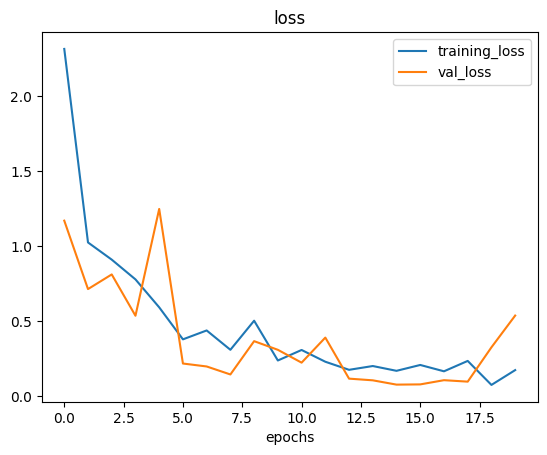

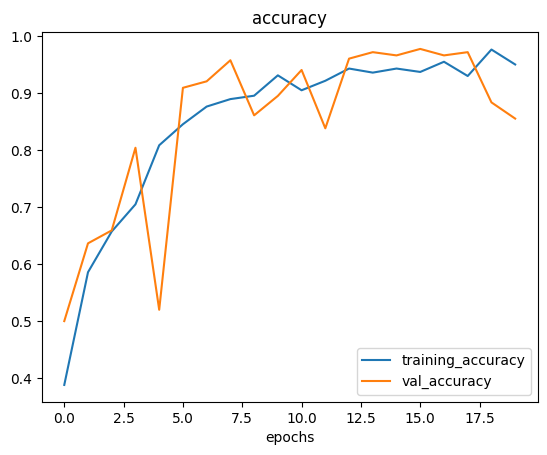

In [117]:
plot_loss_curves(history_1)

In [118]:
early_stop = EarlyStopping(monitor='val_loss', patience=7, restore_best_weights=True, mode='min')
opt = Adam(lr=0.001)

In [119]:
model_1 = Sequential()
model_1.add(Conv2D(32, (3,3), input_shape = (224,224,3), activation="relu"))
model_1.add(MaxPooling2D(2,2))
model_1.add(Conv2D(32, (3,3), activation="relu"))
model_1.add(MaxPooling2D(2,2))
model_1.add(Conv2D(32, (3,3), activation="relu"))
model_1.add(MaxPooling2D(2,2))
model_1.add(Flatten())
model_1.add(Dense(512, activation="relu"))
model_1.add(Dropout(0.2))
model_1.add(Dense(4, activation='softmax'))

In [120]:
model_1.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

In [121]:
history_1_aes = model_1.fit(train_data, epochs=40, steps_per_epoch=len(train_data), 
                                    validation_data=validation_data, validation_steps=validation_data.samples // 32,
                                    callbacks=[early_stop],
                                    batch_size=32)

Epoch 1/40
27/27 [==============================] - 14s 520ms/step - loss: 1.6530 - accuracy: 0.3250 - val_loss: 1.1118 - val_accuracy: 0.3551
Epoch 2/40
27/27 [==============================] - 15s 545ms/step - loss: 0.8035 - accuracy: 0.6000 - val_loss: 0.6614 - val_accuracy: 0.7301
Epoch 3/40
27/27 [==============================] - 16s 589ms/step - loss: 0.9440 - accuracy: 0.5702 - val_loss: 0.9080 - val_accuracy: 0.6705
Epoch 4/40
27/27 [==============================] - 15s 575ms/step - loss: 0.7075 - accuracy: 0.6679 - val_loss: 0.7238 - val_accuracy: 0.6051
Epoch 5/40
27/27 [==============================] - 10s 358ms/step - loss: 0.6308 - accuracy: 0.7048 - val_loss: 0.6245 - val_accuracy: 0.7670
Epoch 6/40
27/27 [==============================] - 8s 285ms/step - loss: 0.5199 - accuracy: 0.7738 - val_loss: 0.5815 - val_accuracy: 0.7756
Epoch 7/40
27/27 [==============================] - 8s 291ms/step - loss: 0.3701 - accuracy: 0.8643 - val_loss: 0.5003 - val_accuracy: 0.8267
E

In [122]:
score_1_aes = model_1.evaluate(test_data)

13/13 [==============================] - 3s 190ms/step - loss: 0.0822 - accuracy: 0.9700


In [123]:
accuracy_list.append(score_1_aes[1])
labels.append('Model 1 - Adam + Early Stop')

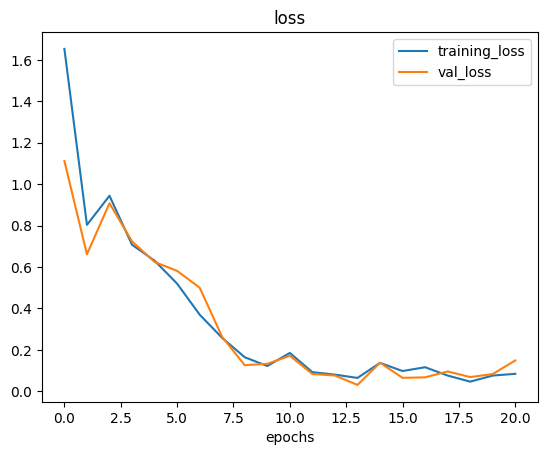

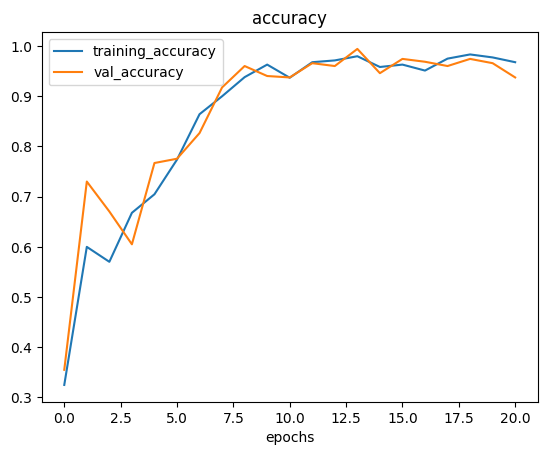

In [124]:
plot_loss_curves(history_1_aes)

In [125]:
model_2 = Sequential()
model_2.add(Conv2D(32, (3,3), input_shape = (224,224,3), activation="relu"))
model_2.add(MaxPooling2D(2,2))
model_2.add(Conv2D(32, (3,3), activation="relu"))
model_2.add(MaxPooling2D(2,2))
model_2.add(Conv2D(32, (3,3), activation="relu"))
model_2.add(MaxPooling2D(2,2))
model_2.add(Conv2D(32, (3,3), activation="relu"))
model_2.add(MaxPooling2D(2,2))
model_2.add(Flatten())
model_2.add(Dense(512, activation="relu"))
model_2.add(Dropout(0.2))
model_2.add(Dense(4, activation='softmax'))

In [126]:
model_2.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])

In [127]:
history_2 = model_2.fit(train_data, epochs=20, steps_per_epoch=len(train_data), validation_data=validation_data, validation_steps=int(0.25 * len(validation_data)))

Epoch 1/20
27/27 [==============================] - 7s 239ms/step - loss: 1.4346 - accuracy: 0.3405 - val_loss: 1.2933 - val_accuracy: 0.3646
Epoch 2/20
27/27 [==============================] - 6s 226ms/step - loss: 1.0212 - accuracy: 0.5905 - val_loss: 0.6767 - val_accuracy: 0.7500
Epoch 3/20
27/27 [==============================] - 6s 224ms/step - loss: 0.6752 - accuracy: 0.7369 - val_loss: 0.3313 - val_accuracy: 0.9271
Epoch 4/20
27/27 [==============================] - 6s 222ms/step - loss: 0.5579 - accuracy: 0.8190 - val_loss: 0.5787 - val_accuracy: 0.7396
Epoch 5/20
27/27 [==============================] - 6s 223ms/step - loss: 0.4107 - accuracy: 0.8869 - val_loss: 1.2797 - val_accuracy: 0.5417
Epoch 6/20
27/27 [==============================] - 6s 222ms/step - loss: 0.4281 - accuracy: 0.8405 - val_loss: 0.3420 - val_accuracy: 0.8854
Epoch 7/20
27/27 [==============================] - 6s 222ms/step - loss: 0.3138 - accuracy: 0.8964 - val_loss: 0.1748 - val_accuracy: 0.9479
Epoch 

In [128]:
score_2 = model_2.evaluate(test_data)

13/13 [==============================] - 3s 192ms/step - loss: 0.1048 - accuracy: 0.9600


In [129]:
accuracy_list.append(score_2[1])
labels.append('Model 2')

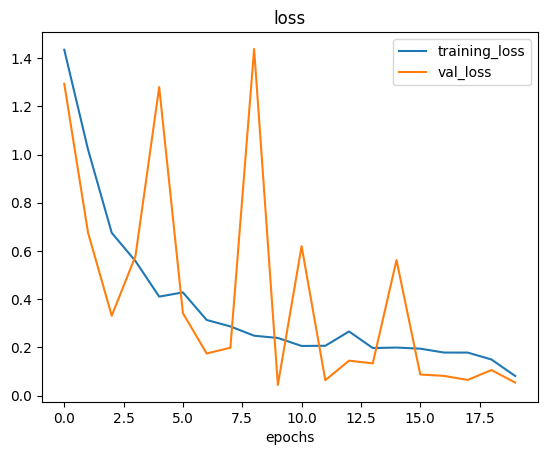

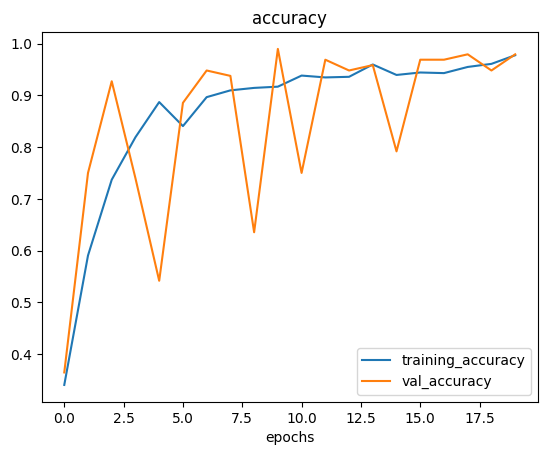

In [130]:
plot_loss_curves(history_2)

In [131]:
model_2 = Sequential()
model_2.add(Conv2D(32, (3,3), input_shape = (224,224,3), activation="relu"))
model_2.add(MaxPooling2D(2,2))
model_2.add(Conv2D(32, (3,3), activation="relu"))
model_2.add(MaxPooling2D(2,2))
model_2.add(Conv2D(32, (3,3), activation="relu"))
model_2.add(MaxPooling2D(2,2))
model_2.add(Conv2D(32, (3,3), activation="relu"))
model_2.add(MaxPooling2D(2,2))
model_2.add(Flatten())
model_2.add(Dense(512, activation="relu"))
model_2.add(Dropout(0.2))
model_2.add(Dense(4, activation='softmax'))

In [132]:
model_2.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics=['accuracy'])

In [133]:
history_2_aes = model_2.fit(train_data, epochs=50, steps_per_epoch=len(train_data), 
                                        validation_data=validation_data, validation_steps=int(0.25 * len(validation_data)),
                                        callbacks=[early_stop])

Epoch 1/50
27/27 [==============================] - 7s 236ms/step - loss: 1.4164 - accuracy: 0.2619 - val_loss: 1.3545 - val_accuracy: 0.3333
Epoch 2/50
27/27 [==============================] - 6s 230ms/step - loss: 1.1034 - accuracy: 0.4929 - val_loss: 0.8943 - val_accuracy: 0.6146
Epoch 3/50
27/27 [==============================] - 6s 230ms/step - loss: 0.7810 - accuracy: 0.6476 - val_loss: 0.6334 - val_accuracy: 0.7708
Epoch 4/50
27/27 [==============================] - 6s 227ms/step - loss: 0.6406 - accuracy: 0.7131 - val_loss: 0.6506 - val_accuracy: 0.6667
Epoch 5/50
27/27 [==============================] - 6s 227ms/step - loss: 0.5701 - accuracy: 0.7619 - val_loss: 0.4612 - val_accuracy: 0.7917
Epoch 6/50
27/27 [==============================] - 6s 232ms/step - loss: 0.3612 - accuracy: 0.8810 - val_loss: 0.4662 - val_accuracy: 0.7917
Epoch 7/50
27/27 [==============================] - 6s 232ms/step - loss: 0.2105 - accuracy: 0.9321 - val_loss: 0.2395 - val_accuracy: 0.9271
Epoch 

In [134]:
score_2_aes = model_2.evaluate(test_data)

13/13 [==============================] - 3s 190ms/step - loss: 0.0682 - accuracy: 0.9700


In [135]:
accuracy_list.append(score_2_aes[1])
labels.append('Model 2 - Adam + Early Stop')

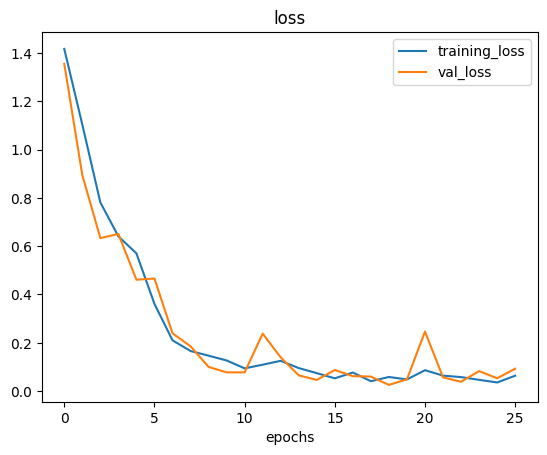

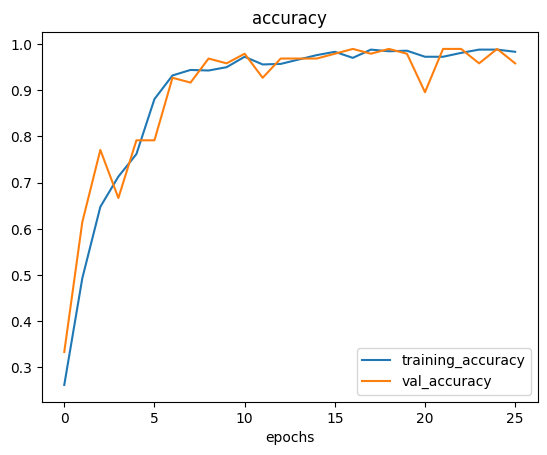

In [136]:
plot_loss_curves(history_2_aes)

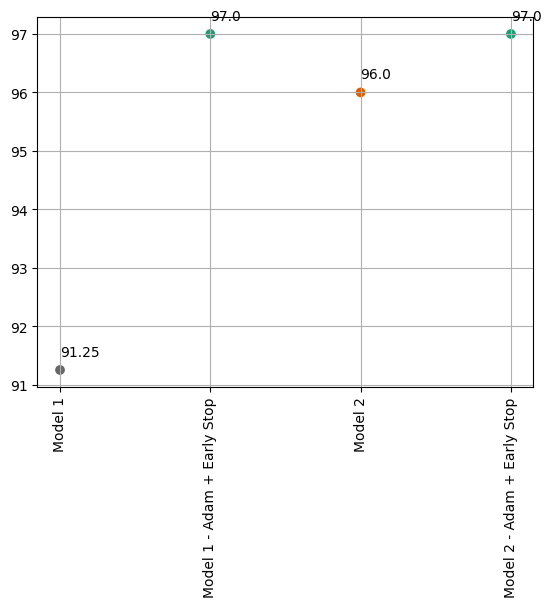

In [137]:
show_results(accuracy_list, labels)

### Custom Loss Function

In [138]:
import tensorflow.keras.backend as K;

def customLossFunc(y_true, y_pred):
    y_true = K.clip(y_true, K.epsilon(), 1)
    y_pred = K.clip(y_pred, K.epsilon(), 1)
    return K.sum(y_true * K.log(y_true / y_pred), axis=-1)

In [139]:
model_1 = Sequential()
model_1.add(Conv2D(32, (3,3), input_shape = (224,224,3), activation="relu"))
model_1.add(MaxPooling2D(2,2))
model_1.add(Conv2D(32, (3,3), activation="relu"))
model_1.add(MaxPooling2D(2,2))
model_1.add(Conv2D(32, (3,3), activation="relu"))
model_1.add(MaxPooling2D(2,2))
model_1.add(Flatten())
model_1.add(Dense(512, activation="relu"))
model_1.add(Dropout(0.2))
model_1.add(Dense(4, activation='softmax'))

In [140]:
model_1.compile(loss = customLossFunc, optimizer = 'rmsprop', metrics=['accuracy'])

In [141]:
history_1_with_custom = model_1.fit(train_data, epochs=20, steps_per_epoch=len(train_data), validation_data=validation_data, validation_steps=validation_data.samples // 32)

Epoch 1/20
27/27 [==============================] - 8s 291ms/step - loss: 2.2413 - accuracy: 0.3131 - val_loss: 1.2178 - val_accuracy: 0.3324
Epoch 2/20
27/27 [==============================] - 8s 281ms/step - loss: 1.0407 - accuracy: 0.5060 - val_loss: 0.8516 - val_accuracy: 0.6193
Epoch 3/20
27/27 [==============================] - 8s 285ms/step - loss: 0.9410 - accuracy: 0.5917 - val_loss: 0.8563 - val_accuracy: 0.6051
Epoch 4/20
27/27 [==============================] - 8s 288ms/step - loss: 0.7923 - accuracy: 0.6798 - val_loss: 0.4724 - val_accuracy: 0.8466
Epoch 5/20
27/27 [==============================] - 8s 278ms/step - loss: 0.6053 - accuracy: 0.7524 - val_loss: 0.4339 - val_accuracy: 0.8409
Epoch 6/20
27/27 [==============================] - 7s 276ms/step - loss: 0.5293 - accuracy: 0.8000 - val_loss: 0.5340 - val_accuracy: 0.7756
Epoch 7/20
27/27 [==============================] - 7s 275ms/step - loss: 0.3722 - accuracy: 0.8548 - val_loss: 0.3481 - val_accuracy: 0.8636
Epoch 

In [142]:
score_1_with_custom = model_1.evaluate(test_data)

13/13 [==============================] - 3s 190ms/step - loss: 0.1467 - accuracy: 0.9575


In [143]:
print('Score without custom loss: ' + str(score_1[1] * 100))
print('Score with custom loss: ' + str(score_1_with_custom[1] * 100))

Score without custom loss: 91.25000238418579
Score with custom loss: 95.74999809265137


### Overfitting

#### Model without Dropout layer and with more epochs

In [79]:
model_3 = Sequential()
model_3.add(Conv2D(32, (3,3), input_shape = (224,224,3), activation="relu"))
model_3.add(MaxPooling2D(2,2))
model_3.add(Conv2D(32, (3,3), activation="relu"))
model_3.add(MaxPooling2D(2,2))
model_3.add(Conv2D(32, (3,3), activation="relu"))
model_3.add(MaxPooling2D(2,2))
model_3.add(Flatten())
model_3.add(Dense(512, activation="relu"))
model_3.add(Dense(4, activation='softmax'))

In [80]:
model_3.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])

In [35]:
history_3 = model_3.fit(train_data, epochs=100, steps_per_epoch=len(train_data), validation_data=validation_data, validation_steps=validation_data.samples // 32)

Epoch 1/100
27/27 [==============================] - 8s 288ms/step - loss: 2.1780 - accuracy: 0.3333 - val_loss: 1.1448 - val_accuracy: 0.4915
Epoch 2/100
27/27 [==============================] - 8s 279ms/step - loss: 0.8470 - accuracy: 0.6548 - val_loss: 0.7305 - val_accuracy: 0.6420
Epoch 3/100
27/27 [==============================] - 8s 281ms/step - loss: 0.6721 - accuracy: 0.7881 - val_loss: 0.4256 - val_accuracy: 0.8295
Epoch 4/100
27/27 [==============================] - 7s 275ms/step - loss: 0.4832 - accuracy: 0.8333 - val_loss: 0.2291 - val_accuracy: 0.9545
Epoch 5/100
27/27 [==============================] - 8s 278ms/step - loss: 0.3352 - accuracy: 0.8929 - val_loss: 0.4904 - val_accuracy: 0.7926
Epoch 6/100
27/27 [==============================] - 8s 288ms/step - loss: 0.3257 - accuracy: 0.8583 - val_loss: 0.1343 - val_accuracy: 0.9659
Epoch 7/100
27/27 [==============================] - 8s 318ms/step - loss: 0.3036 - accuracy: 0.9167 - val_loss: 0.1624 - val_accuracy: 0.9489

In [37]:
score_3 = model_3.evaluate(test_data)

13/13 [==============================] - 3s 180ms/step - loss: 0.0121 - accuracy: 0.9925


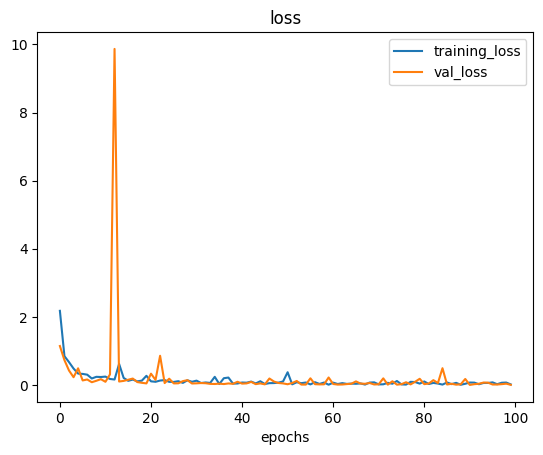

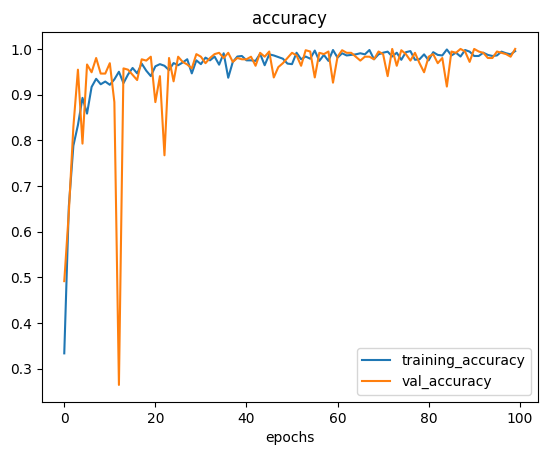

In [36]:
plot_loss_curves(history_3)

#### Less images and no augmentation

In [144]:
train_data_generator = ImageDataGenerator(
        rescale=1./255,
        validation_split=0.6)

train_data = train_data_generator.flow_from_directory('data/train/', target_size=(224, 224), shuffle=True, 
                                                       subset='training', class_mode='categorical')

Found 480 images belonging to 4 classes.


In [145]:
model_4 = Sequential()
model_4.add(Conv2D(32, (3,3), input_shape = (224,224,3), activation="relu"))
model_4.add(MaxPooling2D(2,2))
model_4.add(Conv2D(32, (3,3), activation="relu"))
model_4.add(MaxPooling2D(2,2))
model_4.add(Conv2D(32, (3,3), activation="relu"))
model_4.add(MaxPooling2D(2,2))
model_4.add(Conv2D(32, (3,3), activation="relu"))
model_4.add(MaxPooling2D(2,2))
model_4.add(Flatten())
model_4.add(Dense(512, activation="relu"))
model_4.add(Dense(4, activation='softmax'))

In [146]:
model_4.compile(loss = 'categorical_crossentropy', optimizer = 'rmsprop', metrics=['accuracy'])

In [147]:
history_4 = model_4.fit(train_data, epochs=100, steps_per_epoch=len(train_data), validation_data=test_data, validation_steps=test_data.samples // 32)

Epoch 1/100
15/15 [==============================] - 4s 269ms/step - loss: 1.7030 - accuracy: 0.3104 - val_loss: 1.3575 - val_accuracy: 0.2812
Epoch 2/100
15/15 [==============================] - 4s 244ms/step - loss: 1.3683 - accuracy: 0.4938 - val_loss: 1.4824 - val_accuracy: 0.3854
Epoch 3/100
15/15 [==============================] - 4s 248ms/step - loss: 1.0135 - accuracy: 0.5771 - val_loss: 1.6274 - val_accuracy: 0.3464
Epoch 4/100
15/15 [==============================] - 4s 245ms/step - loss: 0.7967 - accuracy: 0.6917 - val_loss: 1.2397 - val_accuracy: 0.4271
Epoch 5/100
15/15 [==============================] - 4s 246ms/step - loss: 0.6542 - accuracy: 0.7479 - val_loss: 0.7801 - val_accuracy: 0.6615
Epoch 6/100
15/15 [==============================] - 4s 246ms/step - loss: 0.3980 - accuracy: 0.8604 - val_loss: 0.6007 - val_accuracy: 0.7656
Epoch 7/100
15/15 [==============================] - 4s 245ms/step - loss: 0.5544 - accuracy: 0.7979 - val_loss: 0.8231 - val_accuracy: 0.6562

In [148]:
score_4 = model_4.evaluate(test_data)

13/13 [==============================] - 3s 178ms/step - loss: 2.0146 - accuracy: 0.7750


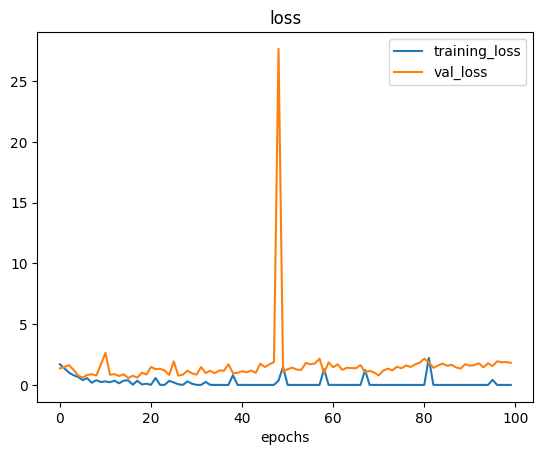

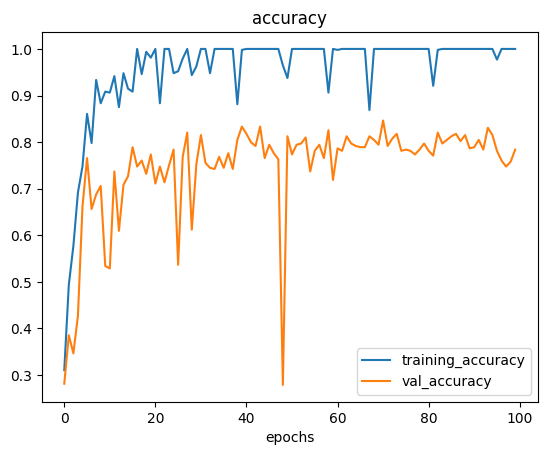

In [149]:
plot_loss_curves(history_4)